<a href="https://colab.research.google.com/github/amir9ume/practice_work/blob/master/HMM_And_Viterbi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6269 - Homework 4 - Hidden Markov Models
**Due:**  Tuesday, November 26, 2019

#### Name: Amir Raza
#### Student ID: 20139365
#### Collaborators: Mostafa ElAraby



## Introduction

The file `EMGaussian.train` contains samples of data $\{x_t\}_{t=1}^T$ where $x_t \in \mathbb{R}^2$, with one datapoint per row. `EMGaussian.test` is structured similarly. This is the same data we used in Homework 3, but this time we use an HMM model to account for the possible temporal structure of the data. This means that we now consider each row of the dataset to be a point $x_t \in \mathbb{R}^2$ corresponding to some temporal process, rather than thinking of them as *independent* samples as we did in the last homework. 

We consider the following HMM model: the chain $(z_t)_{t=1}^T$ has  $K=4$ possible states, with an initial probability distribution $\pi\in\Delta_4$ and a probability transition matrix  $A \in \mathbb{R}^{4 \times 4}$ where $A_{ij} = p(z_t=i | z_{t-1} = j),$ and conditionally on the current state $z_t$, we have observations obtained from Gaussian emission probabilities $x_t| (z_t=k) \sim \mathcal{N}(x_t | \mu_k, \Sigma_k)$.  This is thus a generalization of a GMM since we now allow for time dependencie across the latent states $z_t$.

This exercise has several implementation objectives:
* **Sum-product**: probabilistic inference on the HMM
* **Expectation-Maximization**: parameter estimation
* **Viterbi**: decoding.

**Note:** You may use the (*possibly corrected*) code you created for the previous assignment. Furthermore, notice there are some math questions in this notebook: do not forget to solve them! 

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw4_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
4.   Complete the exercises in the sections **Sum-product**, **Expectation-Maximization**, **Viterbi**, **Comparing methods** and **What about K?**.
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [ ]:
!wget http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A19/notes/hwk3data.zip
!unzip hwk3data.zip

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

X_train = np.loadtxt("/content/hwk3data/EMGaussian.train")
X_test = np.loadtxt("/content/hwk3data/EMGaussian.test")

--2019-11-28 04:15:36--  http://www.iro.umontreal.ca/~slacoste/teaching/ift6269/A19/notes/hwk3data.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7269 (7.1K) [application/zip]
Saving to: ‘hwk3data.zip’

hwk3data.zip        100%[===================>]   7.10K  --.-KB/s    in 0s      

2019-11-28 04:15:36 (448 MB/s) - ‘hwk3data.zip’ saved [7269/7269]

Archive:  hwk3data.zip
  inflating: hwk3data/EMGaussian.test  
  inflating: hwk3data/EMGaussian.train  


## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions we provided!

In [ ]:
#@title
# ---------------------------------------------------------------------------
#                       Code for plotting the results 
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

def plot_smoothing(gamma, K=4, time_limit=100):
    plt.figure(figsize=(14, 2*K))
    plt.suptitle('Smoothing probabilities $p(z_t|x_1, ..., x_T)$', fontsize=16)
    for k in range(K):
        plt.subplot(K, 1, 1+k)
        plt.plot(range(1, time_limit+1), gamma[:time_limit, k] )
        plt.ylabel(r'$p(z_t = ' + str(k+1) + ' | x_{1:T})$')
        plt.ylim(0, 1)
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

def plot_labelling(X, labels, mus, title=""):
    shapes = ['o', '*', 'v', '+']  
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
              [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]

    fig = plt.figure(figsize=(5, 5))
    cs = [colors[int(_) % len(colors)] for _ in labels]
    plt.scatter(X[:, 0], X[:, 1], c=np.array(cs)/255.)
    plt.scatter(mus[:, 0], mus[:, 1], marker='o', c='#d62728')
    plt.xlim(-12, 12), plt.ylim(-12, 12)
    plt.title(title, fontsize=16)        
    plt.show()

def plot_dominoes(data):
    # Pick max from data per timestep
    data_maxhot = (data == data.max(axis=1, keepdims=True))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 3)
    ax.pcolor(1 - data_maxhot[:100,::-1].T, cmap=plt.cm.gray, alpha=0.6)
    ax.set_yticks(np.arange(4) + 0.5, minor=False)
    ax.set_yticklabels([4,3,2,1], minor=False)
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

## Sum-product [15 pts]

### $\alpha$, $\beta$ recursions

Implement the $\alpha$ and $\beta$-recursions seen in class (and that can be found in chapter 12 of Mike's book with slightly different notation). Recall that $\alpha(z_t) := p(z_t, x_{1:t})$, $\beta(z_t) := p(x_{(t+1):T} | z_t)$. Implement also a function to compute the emission probabilties $\epsilon_k(x_t) := p(x_t|z_t=k) = \mathcal{N}(x_t|\mu_k, \Sigma_k)$.

For numerical stability reasons, you are expected to implement your algorithms using **log probabilities** unless noted explicitly!



In [ ]:
from scipy.stats import multivariate_normal


def log_emission(X, mus, sigmas) :
    """
    (Log) probabilities under a Gaussian emission model for a time-homogeneous HMM 

    Inputs:
        X: [Tx2] matrix of observations
        mus: [Kx2] matrix of latent-conditional emission means
        sigmas: [Kx2x2] tensor of latent-conditional emission covariance matrices
         
    Returns:
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    """
    T, K = X.shape[0], mus.shape[0]
    log_eps = np.zeros((T, K))
    eps=np.zeros((T,K))
    for k in range(K):
        log_eps[:,k]=multivariate_normal.logpdf(X, mean=mus[k,:], cov=sigmas[k,:,:])
    
    return log_eps

def log_alpha_recursion(X, A, log_eps, pi) :
    """
    (Log) alpha recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
        pi: [Kx1] initial latent state distribution
    
    Returns:
        log_alpha: [TxK] vector containing log p(z_t , x_{1:t})
    """
    T, K = log_eps.shape

    # TODO
    log_alpha = np.zeros((T, K))

    log_alpha[0,:] = np.log(pi) + log_eps[0,:]

    
    for t in range(1, T):
        for k in range(K):
     
            #find max amax returns max value of an array
            z= np.amax(log_alpha[t-1,:]+ np.log(A[:,k]) + log_eps[t,k])
            summed_terms= (log_alpha[t-1,:] + np.log(A[:,k]) + log_eps[t,k])
            diff_terms= summed_terms - z
            exp_diff_terms= np.exp(diff_terms)
            summed_exp_diff_terms= np.sum(exp_diff_terms)
            log_sum= z + np.log(summed_exp_diff_terms)
            log_alpha[t,k]= log_sum 
   # print('log alpha ',log_alpha)        
    return log_alpha

def log_beta_recursion(X, A, log_eps) :
    """
    (Log) beta recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    
    Returns:
        log_beta: [TxK] vector containing log p(z_{t+1:T} | z_t)
    """
    T, K = log_eps.shape
    
    log_beta = np.zeros((T,K))
    log_beta[T-1] = np.zeros((K,))

    for t in range(T-2, -1,-1):
        for k in range(K):
            z= np.amax(log_beta[t+1,:]+ np.log(A[k,:]) + log_eps[t+1,:] )
            summed_terms= log_beta[t+1,:]+ np.log(A[k,:]) + log_eps[t+1,:]
            diff_terms= summed_terms - z
            exp_diff_terms= np.exp(diff_terms)
            
            summed_exp_diff_terms= np.sum(exp_diff_terms)
            log_sum= z + np.log(summed_exp_diff_terms)
            log_beta[t,k]= log_sum 
  
   # print('log beta ',log_beta)
    # This redundant line is just a reminder to leave the T-th row (python's (T-1)-th)
    # empty: Look at the equation for beta(z_T). We do this to keep equal sizes
    # for alpha and beta recursions.
    return log_beta

Using the two functions above, implement the computation of the *smoothing* distribution $p(z_t|x_1,\dots,x_T)$ and pair-marginals $p(z_t,z_{t+1}|x_1,\dots,x_T)$. Here use log probabilities from the $\alpha$ and $\beta$, but return a normal (not log!) probability, i.e, a number in $[0,1]$.

In [ ]:
from scipy.special import logsumexp

def likelihood(log_alpha):
    #calculates p(X). X is complete observation from 1 to T
    T= log_alpha.shape[0]
    likelihood= logsumexp(log_alpha[T-1,:])/log_alpha.shape[0]
    
    return likelihood

def smoothing(log_alpha, log_beta):
    """
    Smoothing probabilities for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        log_alpha: [TxK] matrix containing log p(z_t , x_{1:t})
        log_beta: [TxK] matrix containing log p(z_{t+1:T} | z_t)
    
    Returns:
        gamma: [TxK] matrix of smoothing probabilities p(z_t | x_{1:T})
    """
    T, K = log_alpha.shape

    # TODO
    gamma = np.zeros((T, K))
    log_gamma=np.zeros((T,K))



    for t in range(T):
        for k in range(K):
            log_gamma[t,k]= log_alpha[t,k] + log_beta[t,k]
            #do log sum of this
        d= logsumexp(log_gamma[t,:])
        log_gamma[t,:]-= d
    gamma = np.exp(log_gamma)

  #  print('cross check sum of gamma is ', np.sum(gamma, axis=1))
    return gamma

def pair_marginals(log_alpha, log_beta, A, log_eps):
    """
    Pair marginals for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        log_alpha: [TxK] matrix containing log p(z_t , x_{1:t})
        log_beta: [TxK] matrix containing log p(z_{t+1:T} | z_t)
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    
    Returns:
        psi: [TxKxK] numpy tensor of pair marginal probabilities p(z_t, z_{t+1} | x_{1:T})
    """
    T, K = log_alpha.shape

    # TODO
    psi = np.zeros((T, K, K))
    log_num= np.zeros((T, K, K))
     # Just as above, we keep psi of length T on the first dimension
    
    gamma= smoothing(log_alpha, log_beta)
    for t in range(T-1):
      for k in range(K):  
          for k2 in range(K):
              psi[t,k,k2]= np.exp(log_alpha[t,k] + np.log(gamma[t+1,k2]) + np.log(A[k,k2]) + log_eps[t+1,k2] - log_alpha[t+1,k2])
    psi[T-1, ...] = np.zeros((K,K))
    #psi=np.exp(log_num)
    return psi

### Inference with ad hoc parameters

Consider using the same parameters for the means and covariance matrix of the 4 Gaussians that you should have learned in Homework 3 for EM with general covariance matrices. For convenience, we give to you below:
\begin{align*}
\mu_1 &= \left( \begin{aligned}
-2&.0344 \\
4&.1726
\end{aligned}
\right) &
\mu_2 &= \left( \begin{aligned}
3&.9779 \\
3&.7735
\end{aligned}
\right) &
\mu_3 &= \left( \begin{aligned}
3&.8007 \\
-3&.7972
\end{aligned}
\right) &
\mu_4 &= \left( \begin{aligned}
-3&.0620 \\
-3&.5345
\end{aligned}
\right) &
\end{align*}

\begin{align*}
\Sigma_1 &= \left( \begin{aligned}
2&.9044 &   0&.2066 \\
0&.2066 &   2&.7562
\end{aligned}
\right) &
\Sigma_2 &= \left( \begin{aligned}
0&.2104 &   0&.2904 \\
0&.2904 &   12&.2392
\end{aligned}
\right) 
\\
\\
\Sigma_3 &= \left( \begin{aligned}
0&.9213 &   0&.0574 \\
0&.0574 &   1&.8660
\end{aligned}
\right) &
\Sigma_4 &= \left( \begin{aligned}
6&.2414 &   6&.0502 \\
6&.0502 &   6&.1825
\end{aligned}
\right) 
\end{align*}



Consider a uniform initial probability distribution $\pi_k = \frac{1}{4}$, and set $A$ to be the matrix with diagonal coefficients $A_{ii}=\frac{1}{2}$ and off-diagonal coefficients $A_{ij}=\frac{1}{6}$ for all $(i,j) \in \{1,\ldots,4\}^2$.

In [ ]:
# We have already typed in all these wonderful numbers for you ;)
K = 4

pi = np.array(4 * [1/4])

A = (1/2) * np.eye(4) + (1/6) * (np.ones(4) - np.eye(4))

mus = np.array([[-2.0344, 4.1726], \
                      [3.9779 , 3.7735], \
                      [3.8007 ,-3.7972], \
                      [-3.0620,-3.5345]]) 

sigmas = np.array([[[2.9044, 0.2066],[0.2066, 2.7562 ]],  \
                   [[0.2104, 0.2904],[0.2904, 12.2392]],  \
                   [[0.9213, 0.0574],[0.0574, 1.8660 ]],  \
                   [[6.2414, 6.0502],[6.0502, 6.1825 ]]])

# We store this for EM later
INIT_PARAMS = (K, pi, A, mus, sigmas)

Let $\{x_1,\dots,x_T\}$ be the **test** data. Using your functions above, for all $t$ on the test data, compute $\log(\alpha_t)$, $\log(\beta_t)$ and  $p(z_t | x_1,\dots,x_T)$. Finally, plot $p(z_t|x_1,\dots,x_T)$ for each of the 4 states as a function of $t$ for the first 100 timesteps. 

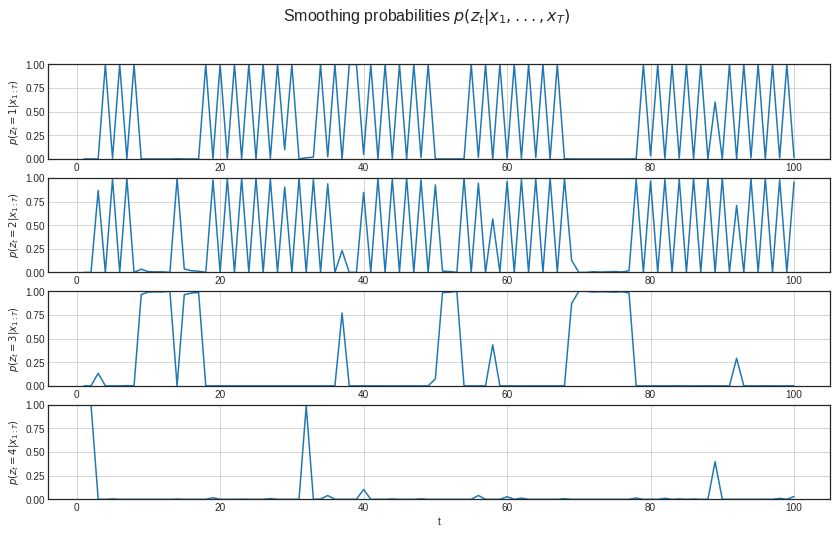

In [ ]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
log_eps = log_emission(X_test, mus, sigmas)

# Perform (log) alpha and beta recursions
log_alpha = log_alpha_recursion(X_test, A, log_eps, pi)
log_beta = log_beta_recursion(X_test, A, log_eps)

# Compute smoothing probabilities
gamma = smoothing(log_alpha, log_beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma)



In [ ]:
#pair_marginals(log_alpha, log_beta, A, log_eps)

In [ ]:
#smoothing(log_alpha, log_beta).sum()

## Expectation-Maximization [20 pts]

### M-step updates
Derive the M-step update for $\hat{\pi}$, $\hat{A}$, $\hat{\mu}_k$ and $\hat{\Sigma}_k$ (for $k=1,\ldots, 4)$ during the EM algorithm, as a function of the quantities computed during the E step. Note that for the estimate of $\pi$, we only have *one* long chain here!

**Answer:** The quantities computed in E-step are $\gamma$ and $\xi$.Notice that we need to add two lagrange multiplier constraints on the values of $\pi_k$ and $A_{i,j}$.
In terms of these quantities, the Q-equation to optimize is :
$$Q(\theta, \theta^{old})= \sum_{j=1}^K \gamma_0(j)\log \pi_j -\lambda(\sum_{j=1}^K \pi_j -1) \\+ \sum_{t=1}^{T-1} \sum_{j=1}^K \sum_{i=1}^K \xi_t(i,j) \log A_{i,j} -\lambda_2(\sum_{j=1}^K A_{i,j} -1) + \sum_{t=1}^T \sum_{j=1}^K \gamma_j(t) \log p(x_t \mid \phi_k) $$
where K states are present, and $\phi_k$ is set of $\mu_k$,$\Sigma_k$ for each class.
Taking derivative with respect to $\pi_k$ and setting it to 0 for $\hat{\pi}$ update:

$$\frac{\partial Q(\theta, \theta^*) }{\partial \pi_k} = \frac{\gamma_t(k)}{\pi_k} -\lambda =0$$
$$\implies  \gamma_0(k) = \lambda \pi_k $$

Since we know that $\sum_{k=1}^K \pi_k=1$, we sum both sides of equation to K, to get:
$$ \sum_{k=1}^K \gamma_0(k) = \lambda  \sum_{k=1}^K\pi_k  $$

Also as $\sum_{k=1}^K \gamma_t(k)=1$

$$\implies 1 = \lambda * 1  $$
$$\implies 1= \lambda $$

Using this in the result before , we get:

$$\implies  \gamma_0(k) = \hat{\pi_k} $$

Taking derivative with respect to $A_{i,j}$ and setting it to 0 will give (we treat $\xi(i,j)$ as constant at this step):
$$\frac{\partial Q(\theta, \theta^*) }{\partial A_{i,j}}=0= \sum_{t=1}^{T-1} \xi_t(i,j) \frac{1}{A_{i,j}} - \lambda_2 A_{i,j}$$
$$\implies \sum_{t=1}^{T-1} \xi_t(i,j) \frac{1}{A_{i,j}} = \lambda_2 A_{i,j} $$
As we know that $\sum_{j=1}^K A_{i,j}=1$, thus:
$$\implies \sum_{t=1}^{T-1} \sum_{j=1}^K \xi_t(i,j) \frac{1}{A_{i,j}} = \lambda_2 \sum_{j=1}^K A_{i,j} $$
$$\implies \sum_{t=1}^{T-1} \sum_{j=1}^K \xi_t(i,j) \frac{1}{A_{i,j}} = \lambda_2  $$

Using this in the original equation we get:
$$\implies \sum_{t=1}^{T-1} \xi_t(i,j) \frac{1}{A_{i,j}} = \sum_{t=1}^{T-1} \sum_{j=1}^K \xi_t(i,j) \frac{1}{A_{i,j}} A_{i,j} $$
$$\implies \sum_{t=1}^{T-1} \xi_t(i,j) \frac{1}{A_{i,j}} = \sum_{t=1}^{T-1} \sum_{j=1}^K \xi_t(i,j)  $$
$$\frac{\sum_{t=1}^{T-1} \xi_t(i,j)}{\sum_{t=1}^{T-1} \sum_{j=1}^K \xi_t(i,j)} = A_{i,j} $$


Looking at the normal probability terms with resepect to set of parameters $\phi_K$, we have:
 $$\sum_{t=1}^T \sum_{j=1}^K \gamma_t(k) \log p(x_t \mid \phi_k)= $$
 $$=\sum_{t=1}^T \sum_{j=1}^K \gamma_t(k)\bigg( \frac{-1}{2}\log (\det \Sigma_k) + const  -\frac{1}{2} (x_i- \mu_k)^T \Sigma_k (x_i- \mu_k) \bigg)$$

 Taking derivative with respect to $\mu_k$ and setting it 0, we have update $\hat{\mu_k}$:
 $$\sum_{t=1}^T \gamma_t(k) (x_i- \mu_k)=0$$
 $$\implies \sum_{t=1}^T \gamma_t(k)x_i = \sum_{t=1}^T \gamma_t(k) \mu_k $$
 $$\implies \frac{\sum_{t=1}^T \gamma_t(k)x_i}{\sum_{t=1}^T \gamma_t(k)} =\mu_k $$

  Instead of taking derivative with respect to $\Sigma_k$ and setting it 0, for $\hat{\Sigma_k}$, we will take derivative with respect to $(\Sigma_k)^{-1}$ (Based on the trick in lecture 10 of Simon's notes):
  Thus derivative with resepect to $(\Sigma_k)^{-1}$:
$$\implies \sum_{t=1}^T \gamma_t(k) \bigg(  \Sigma_k  - (x_i- \mu_k)  (x_i- \mu_k)^T \bigg) =0 $$

$$\implies \sum_{t=1}^T \gamma_t(k) \Sigma_k  = \sum_{t=1}^T \gamma_t(k)(x_i- \mu_k)  (x_i- \mu_k)^T   $$
$$\implies  \Sigma_k= \frac{\sum_{t=1}^T \gamma_t(k)(x_i- \mu_k)  (x_i- \mu_k)^T}{\sum_{t=1}^T \gamma_t(k)}$$


### EM implementation

Implement the EM algorithm to learn the parameters of the model ($\pi,A,\mu_k,\Sigma_k,\: k=1\ldots,4$). Use the parameters from question 2 for initialization.

In [ ]:



def expectation_step(X_tr, A, mus,sigmas, pi):
  
  log_eps=log_emission(X_tr, mus, sigmas)
  
  log_alpha = log_alpha_recursion(X_tr, A, log_eps, pi)
  
  log_beta = log_beta_recursion(X_tr, A, log_eps)
  
  psi = pair_marginals(log_alpha, log_beta, A, log_eps)
  
  gamma= smoothing(log_alpha, log_beta)
  
  print('log alpha', log_alpha)
  print('log beta ', log_beta)
  print('psi ', psi)
  print('gamma ',gamma)

  likel= likelihood(log_alpha)
  return  psi ,gamma , likel


def maximization_step( gamma, psi, X ):
    T,K= log_alpha.shape[0], log_alpha.shape[1]
    
    pi=np.zeros(K)
    for k in range(K):
      pi[k]= gamma[0,k]/np.sum(gamma[0,:])
    
 #   print('sum of pi ', np.sum(pi))
    A= np.zeros((K,K))
      
  
    psi_sum = np.sum(psi,axis=0)
    for i in range(K):
        A[i,:] = psi_sum[i,:] / sum(psi_sum[i,:]) 
    mus=np.zeros((K,2)) 
    denom=np.zeros(K)
    for k in range(K):
 
      mus[k,:]= np.dot(gamma[:,k],X).reshape(-1)
   
      denom[k]=np.sum(gamma[:,k])    
      mus[k,:]/=denom[k]


   # print('mus ',mus)
    
    sigmas=np.zeros((K,2,2))
    for k in range(K):
      for t in range(T):
          diff= (X[t,:]- mus[k,:]).reshape(-1,1)
 
          diff_prod= np.dot(diff,diff.T)
       
          elements= gamma[t,k]*diff_prod 
          sigmas[k,:,:]+=elements
      sigmas[k,:,:]/=denom[k]

  
  #  print('sigmas ',sigmas)
  
   
    return pi, A,  mus,sigmas

def exp_max(X_tr, X_ts, init_params):
    """
    Estimates the parameters of an HMM using training data X via the EM algorithm

    Inputs:
        X_tr: [T_trainx2] matrix of training observations
        X_tr: [T_testx2] matrix of test observations
        init_params: tuple of initialization parameters from previous question
        
    Returns:
        pi: [K] estimated initial latent distribution
        A: [KxK] estimated transition matrix
        mus: [Kx2] matrix of estimated emission means
        sigmas: [Kx2x2] tensor of estimated emission covariance matrices
        train_avg_llike: list containing the average training log likelihood on each iteration
        test_avg_llike: list containing the average test log likelihood on each iteration
    """

    # Set initialization from parameters given in previous question 
    (K, pi, A, mus, sigmas) = init_params
   # log_eps=log_emission_probs(X_tr, mus,sigmas)
  #  print(init_params)
    # TODO
    train_avg_llike  = []
    test_avg_llike  = []

   
    for i in range(20):      
        
        log_eps=log_emission(X_tr, mus, sigmas)
       # print('log eps is ', log_eps)
        log_alpha = log_alpha_recursion(X_tr, A, log_eps, pi)
        log_beta = log_beta_recursion(X_tr, A, log_eps)
        T,K= log_alpha.shape[0], log_alpha.shape[1]
        gamma= smoothing(log_alpha, log_beta)
        psi = pair_marginals(log_alpha, log_beta, A, log_eps)

       # print('gamma is ',gamma)

        likel= likelihood(log_alpha)
        print('likelihood is ',likel)   
        pi=np.zeros(K)
        for k in range(K):
          pi[k]= gamma[0,k]#/np.sum(gamma[0,:])
        
        A= np.zeros((K,K)) 
        psi_sum = np.sum(psi,axis=0)
        for i in range(K):
            A[i,:] = psi_sum[i,:] / sum(psi_sum[i,:]) 

        mus=np.zeros((K,2)) 
        denom=np.zeros(K)
        for k in range(K):
          mus[k,:]= np.dot(gamma[:,k],X_tr).reshape(-1)
          denom[k]=np.sum(gamma[:,k])    
          mus[k,:]/=denom[k]

      #  print('mus ',mus)
        sigmas=np.zeros((K,2,2))
        for k in range(K):
          for t in range(T):
              diff= (X_tr[t,:]- mus[k,:]).reshape(-1,1) 
              diff_prod= np.dot(diff,diff.T)
              elements= gamma[t,k]*diff_prod 
              sigmas[k,:,:]+=elements
          sigmas[k,:,:]/=denom[k]
        
        train_avg_llike.append(likel)
     #   print('sigma ',sigmas)
        #predictions on testing
    
        log_eps_test=log_emission(X_ts, mus, sigmas)
        log_alpha_test = log_alpha_recursion(X_ts, A, log_eps_test, pi)
        test_like=likelihood(log_alpha_test)
        print('test likelihood ',test_like)
        test_avg_llike.append(test_like)
        print('---- iteration---- ')  

        


     
    
    
    
    return pi, A, mus, sigmas, train_avg_llike, test_avg_llike

Learn the parameters of the HMM using the **training** data and plot the average log-likelihood on the train and test data as a function of the iterations of the algorithm. Comment on your observations.

likelihood is  -4.599781970051837
test likelihood  -3.9544073803240885
---- iteration---- 
likelihood is  -3.8250152902248176
test likelihood  -3.9209071969546665
---- iteration---- 
likelihood is  -3.7972182649808732
test likelihood  -3.914309496267443
---- iteration---- 
likelihood is  -3.794046104195956
test likelihood  -3.9120143440991684
---- iteration---- 
likelihood is  -3.793644751360782
test likelihood  -3.9110524818992576
---- iteration---- 
likelihood is  -3.7935870191700065
test likelihood  -3.9106778798405792
---- iteration---- 
likelihood is  -3.7935787539375854
test likelihood  -3.910537512499775
---- iteration---- 
likelihood is  -3.7935775948192716
test likelihood  -3.9104856877109446
---- iteration---- 
likelihood is  -3.793577433665424
test likelihood  -3.910466677951744
---- iteration---- 
likelihood is  -3.793577411294667
test likelihood  -3.910459730094823
---- iteration---- 
likelihood is  -3.793577408184634
test likelihood  -3.910457196796411
---- iteration---- 

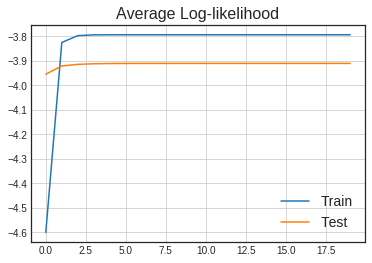

In [ ]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Estimate parameters using EM and collect results
res = exp_max(X_train, X_test, INIT_PARAMS)
pi_em, A_em, mus_em, sigmas_em, train_avg_llike, test_avg_llike = res

# Plot the log-likelihoods
plt.plot(train_avg_llike, label='Train')
plt.plot(test_avg_llike, label='Test')
plt.legend(fontsize=14)
plt.grid(True)
plt.title('Average Log-likelihood', fontsize=16)
plt.show()

Complete the following table with the values of the average log-likelihood for the Gaussian mixture models (with a) scaled identities and b) full covariances) and of the HMM on the train and on the test data. 

**Answer:** 

Method | Train Avg. Log-Like | Test Avg. Log-Like
--- | --- | ---
*Scaled Identities GMM* | -5.279 | -5.229
*Full Covariance GMM* | -4.655 | -4.817
*Hidden Markov Model* | -3.79 | -3.91


Does it make sense to make this comparison? Why? If so, what conclusions can you draw?. Moreover, briefly compare these log-likelihoods those obtained for the different models in the previous homework.

**Answer:** It 'does not' make a lot of sense to make the comparisons between GMM and HMM models. There is some similarity between them in terms of the 'soft' assignments to each of their latent classes. BUT in case of HMM model, moving from one state to another depends on the transition probabilities between the states involved. In case of GMM models, you could observe 1 point of observation from one particular class, and the next from a very different latent class, with no dependence between them. HMM model assumes that there is relation between the different observations, in terms of their hiddent latent classes.


## Viterbi [20 pts]

### Pseudocode

Provide a description and pseudo-code for the Viterbi decoding algorithm (a.k.a. MAP inference algorithm or max-product algorithm) that estimates the most likely sequence of states: $\arg \max_z p(z_1,\dots,z_T | x_1,\dots,x_T)$.

**Answer:**


*   VITERBI(observations of len T,state-graph of len N) returns best-path
*   create a path probability matrix $viterbi[K,T]$ 
*   for each state s from 1 to K do
*       $viterbi[s,1]$←pi_s ∗ emisssion(o1)
*       backpointer[s,1] ← 0
*   for each time step t from 2 to T do
*       for each state s from 1 to K do 
*         viterbi[s,t] ← max viterbi[s , t − 1] ∗ as′,s ∗ emisssion (ot )
*         backpointer[s,t] ← argmax viterbi[s , t − 1] ∗ as′,s ∗ emisssion (ot )
*   bestpathprob←max viterbi[s,T]
*   bestpathpointer←argmax viterbi[s,T]


*   bestpath ← the path starting at state bestpathpointer, that follows backpointer[] to states back in time
*   return bestpath





reference taken from Standford NLP, chapter HMM


### Viterbi implementation

Implement Viterbi decoding.

In [ ]:
def viterbi(X, pi, A, mus, sigmas):
    """
    Viterbi decoding for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        pi: [Kx1] initial latent state distribution
        A: [KxK] transition matrix
        mus: [Kx2] matrix of latent-conditional emission means
        sigmas: [Kx2x2] tensor of latent-conditional emission covariance matrices
         
    Returns:
        z: [TxK] one-hot encoding of most probable state sequence z_{1:T} given x_{1:T}
    """
    
    T, K = X.shape[0], mus.shape[0]
  
  
    z = np.zeros((T, K))
    
    log_T_1=np.zeros((T,K))
    T_1=np.zeros((T,K))
    
    log_eps= log_emission(X,mus,sigmas)

    log_T_1[0,:] = np.log(pi) + log_eps[0,:]
    T_2=np.zeros((T,K))


    
    for t in range(1, T):
       
          T_1[t,:]= (np.max(T_1[t-1,:]+ np.log(A[:,:]),axis= 1 ) + log_eps[t,:])
          T_2[t,:]=np.argmax(T_1[t-1,:]+ np.log(A[:,:]) ,axis=1)
 
    ZT= np.argmax(T_1[T-1,:])   
    y=int(ZT)
   
    zt=np.zeros(T)

   
    for t in range(T-2, -1, -1):
        zt[t]= T_2[t+1,y]
        
        y=int(zt[t])

    
    for t in range(T):
        z[t,:]= np.eye(K)[int(zt[t])]            

  
    return z



Using the set of parameters learned with the EM algorithm on the **training** set, compute the most likely sequence of states for the **training** data with the Viterbi algorithm. Plot your results.

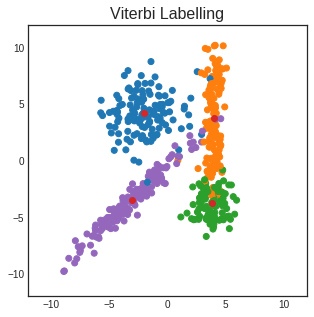

In [ ]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
one_hot_labels =  viterbi(X_train, pi_em, A_em, mus_em, sigmas_em) #np.random.rand(len(X_train), K)
viterbi_labels =  np.argmax(one_hot_labels, axis=1)

# Plot the results
plot_labelling(X_train, viterbi_labels, mus, 'Viterbi Labelling')

## Comparing methods [20 pts]

Use the parameters learned using EM on the **training** set to compute the smoothing marginal probability $p(z_t|x_1,\dots,x_T)$ for each datapoint in the **test** set to be in state $\{1,2,3,4\}$. Plot the probability of being in that state as a function of time for the 100 first points, as before.

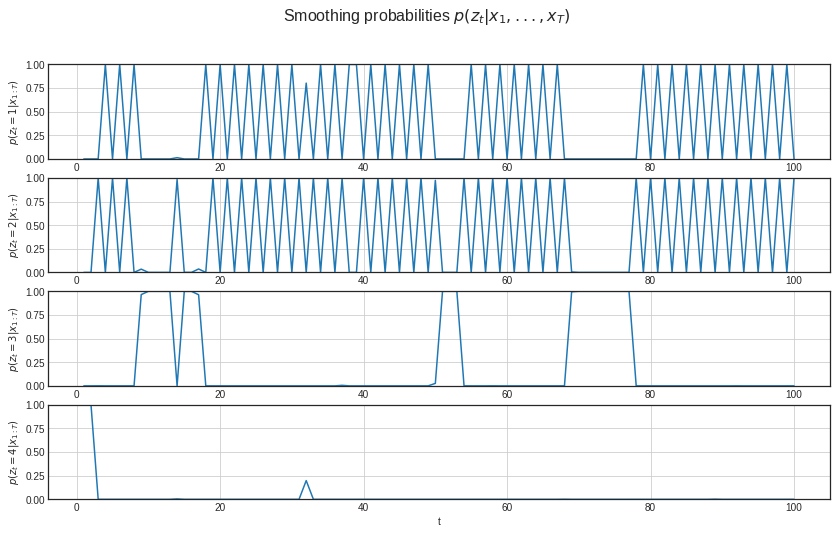

In [ ]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
log_eps = log_emission(X_test, mus_em, sigmas_em)

# Perform (log) alpha and beta recursions
log_alpha = log_alpha_recursion(X_test, A_em, log_eps, pi_em)
log_beta = log_beta_recursion(X_test, A_em, log_eps)

# Compute smoothing probabilities
gamma = smoothing(log_alpha, log_beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma)

For each of these same 100 points, compute their most likely state according to the marginal probability computed in the previous question. Make a plot representing the most likely state in $\{1,2,3,4\}$ as function of time for these 100 points.

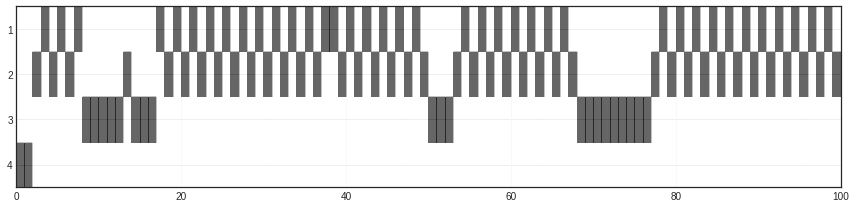

In [ ]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

plot_dominoes(gamma)

Run Viterbi on the **test** data. Make a similar plot.

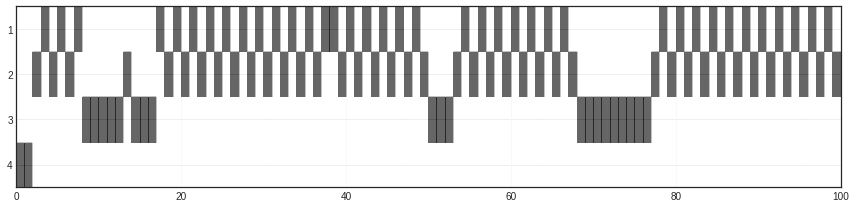

In [ ]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
one_hot_labels = viterbi(X_test, pi_em, A_em, mus_em, sigmas_em)

# Plot the results
plot_dominoes(one_hot_labels)

Compare the most likely sequence of states obtained for the 100 first data points with the sequence of states obtained in the previous question. Comment on your observations.

**Answer:** They are both exactly the same in terms of the states observed. This means that Viterbi algorithm gives similar performance, to the marginal probabilities approach. As Viterbi is a dynamic programming approach, the optimality of the solution requires optimality of every sub-problem involved.


## What about $K$? [5 pts]

In this problem the number of states $K$ was known. How should one choose the number of states if it is unknown a priori?

**Answer:** There is no set approach to find out the number of K. If the number of dimensions of data is limited to 2 , then we could do some plots and check if there is an obvious number of clusters. If the dimension of data is more than 2, then visual approach may not work.
The best we can do then, is to do trial and error, with different number of K, and check the maximization objective values against it.Whichever value of K gives the better value, we can use it as the value of K.
